# Predicting Loyalty Scores

## Import Required Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.linear_model import LinearRegression
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import RFECV

import warnings
warnings.filterwarnings('ignore')

## Import Data

In [2]:
# import data
data_for_model = pickle.load(open("abc_regression_modelling.p", "rb"))
data_for_model.head(5)

,customer_id,distance_from_store,gender,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
0,74,3.38,F,0.59,0.263,2563.71,297,44,5,58.266136
1,524,4.76,F,0.52,0.298,2996.02,357,49,5,61.143265
2,607,4.45,F,0.49,0.337,2853.82,350,49,5,58.241224
3,343,0.91,M,0.54,0.873,2388.31,272,54,5,44.227963
4,322,3.02,F,0.63,0.350,2401.64,278,50,5,48.032800


In [3]:
print(data_for_model.shape)

(400, 10)


In [4]:
# drop necessary columns
data_for_model.drop("customer_id", axis = 1, inplace = True)

In [5]:
print(data_for_model.shape)

(400, 9)


In [6]:
# shuffle data
data_for_model = shuffle(data_for_model, random_state = 42)
data_for_model.head(5)

,distance_from_store,gender,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
455,0.28,M,0.81,0.889,990.65,243,53,4,18.691509
621,2.58,F,0.58,0.162,333.26,70,13,4,25.635385
64,0.80,M,0.80,0.956,1753.96,371,52,5,33.730000
456,0.16,M,0.56,0.926,929.57,225,51,4,18.226863
196,3.27,F,0.67,0.297,1904.55,376,36,3,52.904167


## Deal with missing values

In [7]:
data_for_model.isna().sum()

distance_from_store       2
gender                    3
credit_score              2
customer_loyalty_score    0
total_sales               0
total_items               0
transaction_count         0
product_area_count        0
average_basket_value      0
dtype: int64

In [8]:
data_for_model.dropna(how = "any", inplace = True)
data_for_model.isna().sum()

distance_from_store       0
gender                    0
credit_score              0
customer_loyalty_score    0
total_sales               0
total_items               0
transaction_count         0
product_area_count        0
average_basket_value      0
dtype: int64

## Deal with outliers

In [9]:
# check outliers using descriptive statistics
outlier_investigation = data_for_model.describe()
outlier_investigation

,distance_from_store,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
count,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000
mean,2.021041,0.596117,0.509589,1846.502538,278.304569,44.926396,4.312183,36.781487
std,2.566045,0.101352,0.294504,1767.829482,214.236424,21.248012,0.725054,19.337336
min,0.000000,0.260000,0.002000,45.950000,10.000000,4.000000,2.000000,9.342000
25%,0.710000,0.530000,0.263000,942.067500,201.000000,41.000000,4.000000,22.406953
50%,1.645000,0.590000,0.510500,1471.490000,258.500000,50.000000,4.000000,30.365417
75%,2.910000,0.660000,0.771500,2104.727500,318.500000,53.000000,5.000000,47.208474
max,44.370000,0.880000,1.000000,9878.760000,1187.000000,109.000000,5.000000,102.335417


In [11]:
outlier_columns = ["distance_from_store", "total_sales", "total_items"]

In [12]:
# boxplot approach
for column in outlier_columns:
    
    lower_quartile = data_for_model[column].quantile(0.25)
    upper_quartile = data_for_model[column].quantile(0.75)
    iqr = upper_quartile - lower_quartile
    iqr_extended = iqr * 2 # tried to widen to 2 to not cut out too many outliers
    min_border = lower_quartile - iqr_extended
    max_border = upper_quartile + iqr_extended
    
    outliers = data_for_model[(data_for_model[column] < min_border) | (data_for_model[column] > max_border)].index
    print(f"{len(outliers)} outliers detected in column {column}")
    
    data_for_model.drop(outliers, inplace = True)

2 outliers detected in column distance_from_store
23 outliers detected in column total_sales
0 outliers detected in column total_items


In [13]:
print(data_for_model.shape)

(369, 9)


## Split input variables and output variables

In [14]:
X = data_for_model.drop(["customer_loyalty_score"], axis = 1) # remove target variable from input variable dataframe
y = data_for_model["customer_loyalty_score"] # just the target variable

In [15]:
X.head(5)

,distance_from_store,gender,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
455,0.28,M,0.81,990.65,243,53,4,18.691509
621,2.58,F,0.58,333.26,70,13,4,25.635385
64,0.80,M,0.80,1753.96,371,52,5,33.730000
456,0.16,M,0.56,929.57,225,51,4,18.226863
196,3.27,F,0.67,1904.55,376,36,3,52.904167


In [16]:
print(X.shape)

(369, 8)


In [17]:
y.head(5)

455    0.889
621    0.162
64     0.956
456    0.926
196    0.297
Name: customer_loyalty_score, dtype: float64

In [18]:
print(y.shape)

(369,)


## Split out training and test sets

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [20]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(295, 8)
(74, 8)
(295,)
(74,)


## Deal with categorical variables

In [21]:
categorical_vars = ["gender"]

In [22]:
one_hot_encoder = OneHotEncoder(sparse=False, drop = "first")

In [23]:
X_train_encoded = one_hot_encoder.fit_transform(X_train[categorical_vars])
X_test_encoded = one_hot_encoder.transform(X_test[categorical_vars])

In [25]:
X_train_encoded

array([[1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],

In [26]:
X_test_encoded

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.]])

In [27]:
encoder_feature_names = one_hot_encoder.get_feature_names(categorical_vars)

In [28]:
X_train_encoded = pd.DataFrame(X_train_encoded, columns = encoder_feature_names)
X_train = pd.concat([X_train.reset_index(drop=True), X_train_encoded.reset_index(drop=True)], axis = 1)
X_train.drop(categorical_vars, axis = 1, inplace = True)

In [29]:
X_train_encoded.head(5)

,gender_M
0,1.0
1,1.0
2,0.0
3,0.0
4,1.0


In [31]:
X_train.head(5)

,distance_from_store,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value,gender_M
0,0.19,0.57,1096.96,202,53,5,20.697358,1.0
1,0.39,0.43,933.39,220,51,4,18.301765,1.0
2,2.27,0.49,1506.49,281,47,3,32.052979,0.0
3,3.10,0.59,330.79,81,13,4,25.445385,0.0
4,0.07,0.53,2053.04,210,54,5,38.019259,1.0


In [32]:
X_test_encoded = pd.DataFrame(X_test_encoded, columns = encoder_feature_names)
X_test = pd.concat([X_test.reset_index(drop=True), X_test_encoded.reset_index(drop=True)], axis = 1)
X_test.drop(categorical_vars, axis = 1, inplace = True)

In [33]:
X_test_encoded.head(5)

,gender_M
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [34]:
X_test.head(5)

,distance_from_store,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value,gender_M
0,2.80,0.41,1524.01,278,45,3,33.866889,0.0
1,1.92,0.64,1992.51,305,53,5,37.594528,0.0
2,4.38,0.47,343.41,70,12,4,28.617500,0.0
3,1.51,0.59,1208.91,198,55,5,21.980182,0.0
4,2.52,0.50,1967.39,316,55,5,35.770727,0.0


## Feature Selection

In [35]:
regressor = LinearRegression()
feature_selector = RFECV(regressor)

In [36]:
fit = feature_selector.fit(X_train, y_train)

In [38]:
optimal_feature_count = feature_selector.n_features_
print(f"Optimal number of features: {optimal_feature_count}")

Optimal number of features: 8


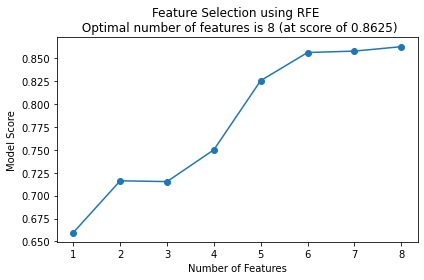

In [41]:
plt.plot(range(1, len(fit.grid_scores_) + 1), fit.grid_scores_, marker = "o")
plt.ylabel("Model Score")
plt.xlabel("Number of Features")
plt.title(f"Feature Selection using RFE \n Optimal number of features is {optimal_feature_count} (at score of {round(max(fit.grid_scores_), 4)})")
plt.tight_layout() 
plt.show()

## Model Training

In [43]:
regressor = LinearRegression()

In [45]:
regressor.fit(X_train, y_train)

LinearRegression()

## Model Assessment

In [46]:
y_pred = regressor.predict(X_test)

In [47]:
# calculate r-squared
r_squared = r2_score(y_test, y_pred)
print(r_squared)

0.7805702910327394


In [49]:
# cross validation (CV)
cv = KFold(n_splits = 4, shuffle = True, random_state = 42)
cv_scores = cross_val_score(regressor, X_train, y_train, cv = cv, scoring = "r2")
cv_scores.mean()

0.8532327536589747

In [50]:
# calculate adjusted r-squared
num_data_points, num_input_vars = X_test.shape
adjusted_r_squared = 1 - (1 - r_squared) * (num_data_points - 1) / (num_data_points - num_input_vars - 1)
print(adjusted_r_squared)

0.7535635576213844


In [51]:
# extract model coefficients
coefficients = pd.DataFrame(regressor.coef_)
input_variable_names = pd.DataFrame(X_train.columns)
summary_stats = pd.concat([input_variable_names, coefficients], axis = 1)
summary_stats.columns = ["input_variable", "coefficient"]

In [52]:
summary_stats.sort_values(by=['coefficient'], ascending=False)

,input_variable,coefficient
5,product_area_count,0.061659
3,total_items,0.001002
2,total_sales,0.000142
6,average_basket_value,-0.003971
4,transaction_count,-0.004842
7,gender_M,-0.013393
1,credit_score,-0.027697
0,distance_from_store,-0.201232


In [53]:
# extract model intercept
regressor.intercept_

0.5160974174646169